# Session 3, Module 1: LLM Evaluation Frameworks

---

## Module Overview

```
┌────────────────────────────────────────────────────────────────────┐
│                                                                    │
│  📚 Session 3, Module 1: LLM Evaluation Frameworks                 │
│                                                                    │
│  🎯 Learning Objectives:                                           │
│     • Understand WHY evaluation is critical for LLM applications   │
│     • Learn key metrics for agent evaluation                       │
│     • Compare evaluation frameworks (when to use which)            │
│     • Integrate DeepEval with the incident-postmortem project      │
│                                                                    │
└────────────────────────────────────────────────────────────────────┘
```

In [2]:
# Workshop Setup
import sys
sys.path.insert(0, '..')

from setup_llm import verify_setup, get_chat_model

verify_setup()

print("\n📚 Session 3, Module 1: LLM Evaluation Frameworks")
print("=" * 60)
print("\n🔗 Prerequisites:")
print("   • Session 2 complete (esp. Module 3: Self-reflection)")
print("   • Familiarity with incident-postmortem project")
print("\n🎯 What you'll learn:")
print("   • WHY LLM evaluation is critical")
print("   • WHAT metrics matter for agents")
print("   • WHICH framework to choose (DeepEval, RAGAS, etc.)")
print("   • HOW to integrate evaluation in your pipeline")

🔍 Checking LLM Configuration...
📡 Provider: DIAL (Azure OpenAI via EPAM AI Proxy)
✅ DIAL_API_KEY is set

📋 Configuration:
   AZURE_OPENAI_ENDPOINT: https://ai-proxy.lab.epam.com
   AZURE_OPENAI_API_VERSION: 2024-08-01-preview
   AZURE_OPENAI_DEPLOYMENT_NAME: gpt-4

✅ DIAL setup verified successfully!

📚 Session 3, Module 1: LLM Evaluation Frameworks

🔗 Prerequisites:
   • Session 2 complete (esp. Module 3: Self-reflection)
   • Familiarity with incident-postmortem project

🎯 What you'll learn:
   • WHY LLM evaluation is critical
   • WHAT metrics matter for agents
   • WHICH framework to choose (DeepEval, RAGAS, etc.)
   • HOW to integrate evaluation in your pipeline


---

## Part 1: Why Evaluation Matters

### The Problem with "Vibe Testing"

> **"Vibe testing is not going to cut it"** - Industry consensus

When developers test LLM applications manually ("Does this look right?"), they encounter several critical issues:

| Problem | Impact | Example |
|---------|--------|--------|
| **Not Scalable** | Can't manually verify thousands of agent runs | A support chatbot handles 10K queries/day |
| **Not Reproducible** | Human judgment varies between reviewers | "Good" response? Depends who you ask |
| **Not Comprehensive** | Misses edge cases and regressions | Works for happy path, fails on edge cases |
| **Not Quantitative** | "Feels good" doesn't inform optimization | Can't A/B test without metrics |

### The Cost of Not Evaluating

```
Production Incident Timeline (Real Example):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Week 1:  ✅ Agent deployed to production after manual "vibe testing"
Week 2:  😟 Customer complaints start trickling in
Week 3:  🔥 Major customer churn - agent was hallucinating pricing info
Week 4:  💸 $500K in refunds + reputation damage

Root Cause: No automated evaluation caught the regression when
           a prompt change caused pricing hallucinations

Prevention: Automated faithfulness + accuracy evaluation in CI/CD
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
```

### When to Evaluate: The Evaluation Loop

Evaluation isn't a one-time activity—it's continuous throughout the development lifecycle.

```
┌─────────────────────────────────────────────────────────────────────┐
│                    CONTINUOUS EVALUATION LOOP                       │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│   ┌──────────────┐     ┌──────────────┐     ┌──────────────┐        │
│   │  DEVELOPMENT │────▶│   STAGING    │────▶│  PRODUCTION  │        │
│   │              │     │              │     │              │        │
│   │  • Unit tests│     │  • Dataset   │     │  • Online    │        │
│   │  • Regression│     │    evaluation│     │    monitoring│        │
│   │  • CI/CD     │     │  • A/B tests │     │  • User      │        │
│   │    evals     │     │  • Benchmark │     │    feedback  │        │
│   └──────────────┘     └──────────────┘     └──────────────┘        │
│           │                   │                    │                │
│           └───────────────────┴────────────────────┘                │
│                               │                                     │
│                    ┌──────────▼──────────┐                          │
│                    │   FEEDBACK LOOP     │                          │
│                    │                     │                          │
│                    │  • Failure analysis │                          │
│                    │  • Dataset updates  │                          │
│                    │  • Prompt iteration │                          │
│                    └─────────────────────┘                          │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### Offline vs Online Evaluation

| Evaluation Type | When | What | Tools |
|-----------------|------|------|-------|
| **Offline (Dev)** | Before deployment | Curated test datasets, known ground truth | DeepEval, RAGAS, pytest |
| **Online (Prod)** | During live traffic | Real user queries, implicit feedback | Langfuse, LangSmith |

---

## Part 2: Key Metrics for Agent Evaluation

Not all metrics are created equal. For **agentic applications**, we need metrics that capture the unique challenges of multi-step, tool-using, reasoning systems.

### The CLASSic Framework

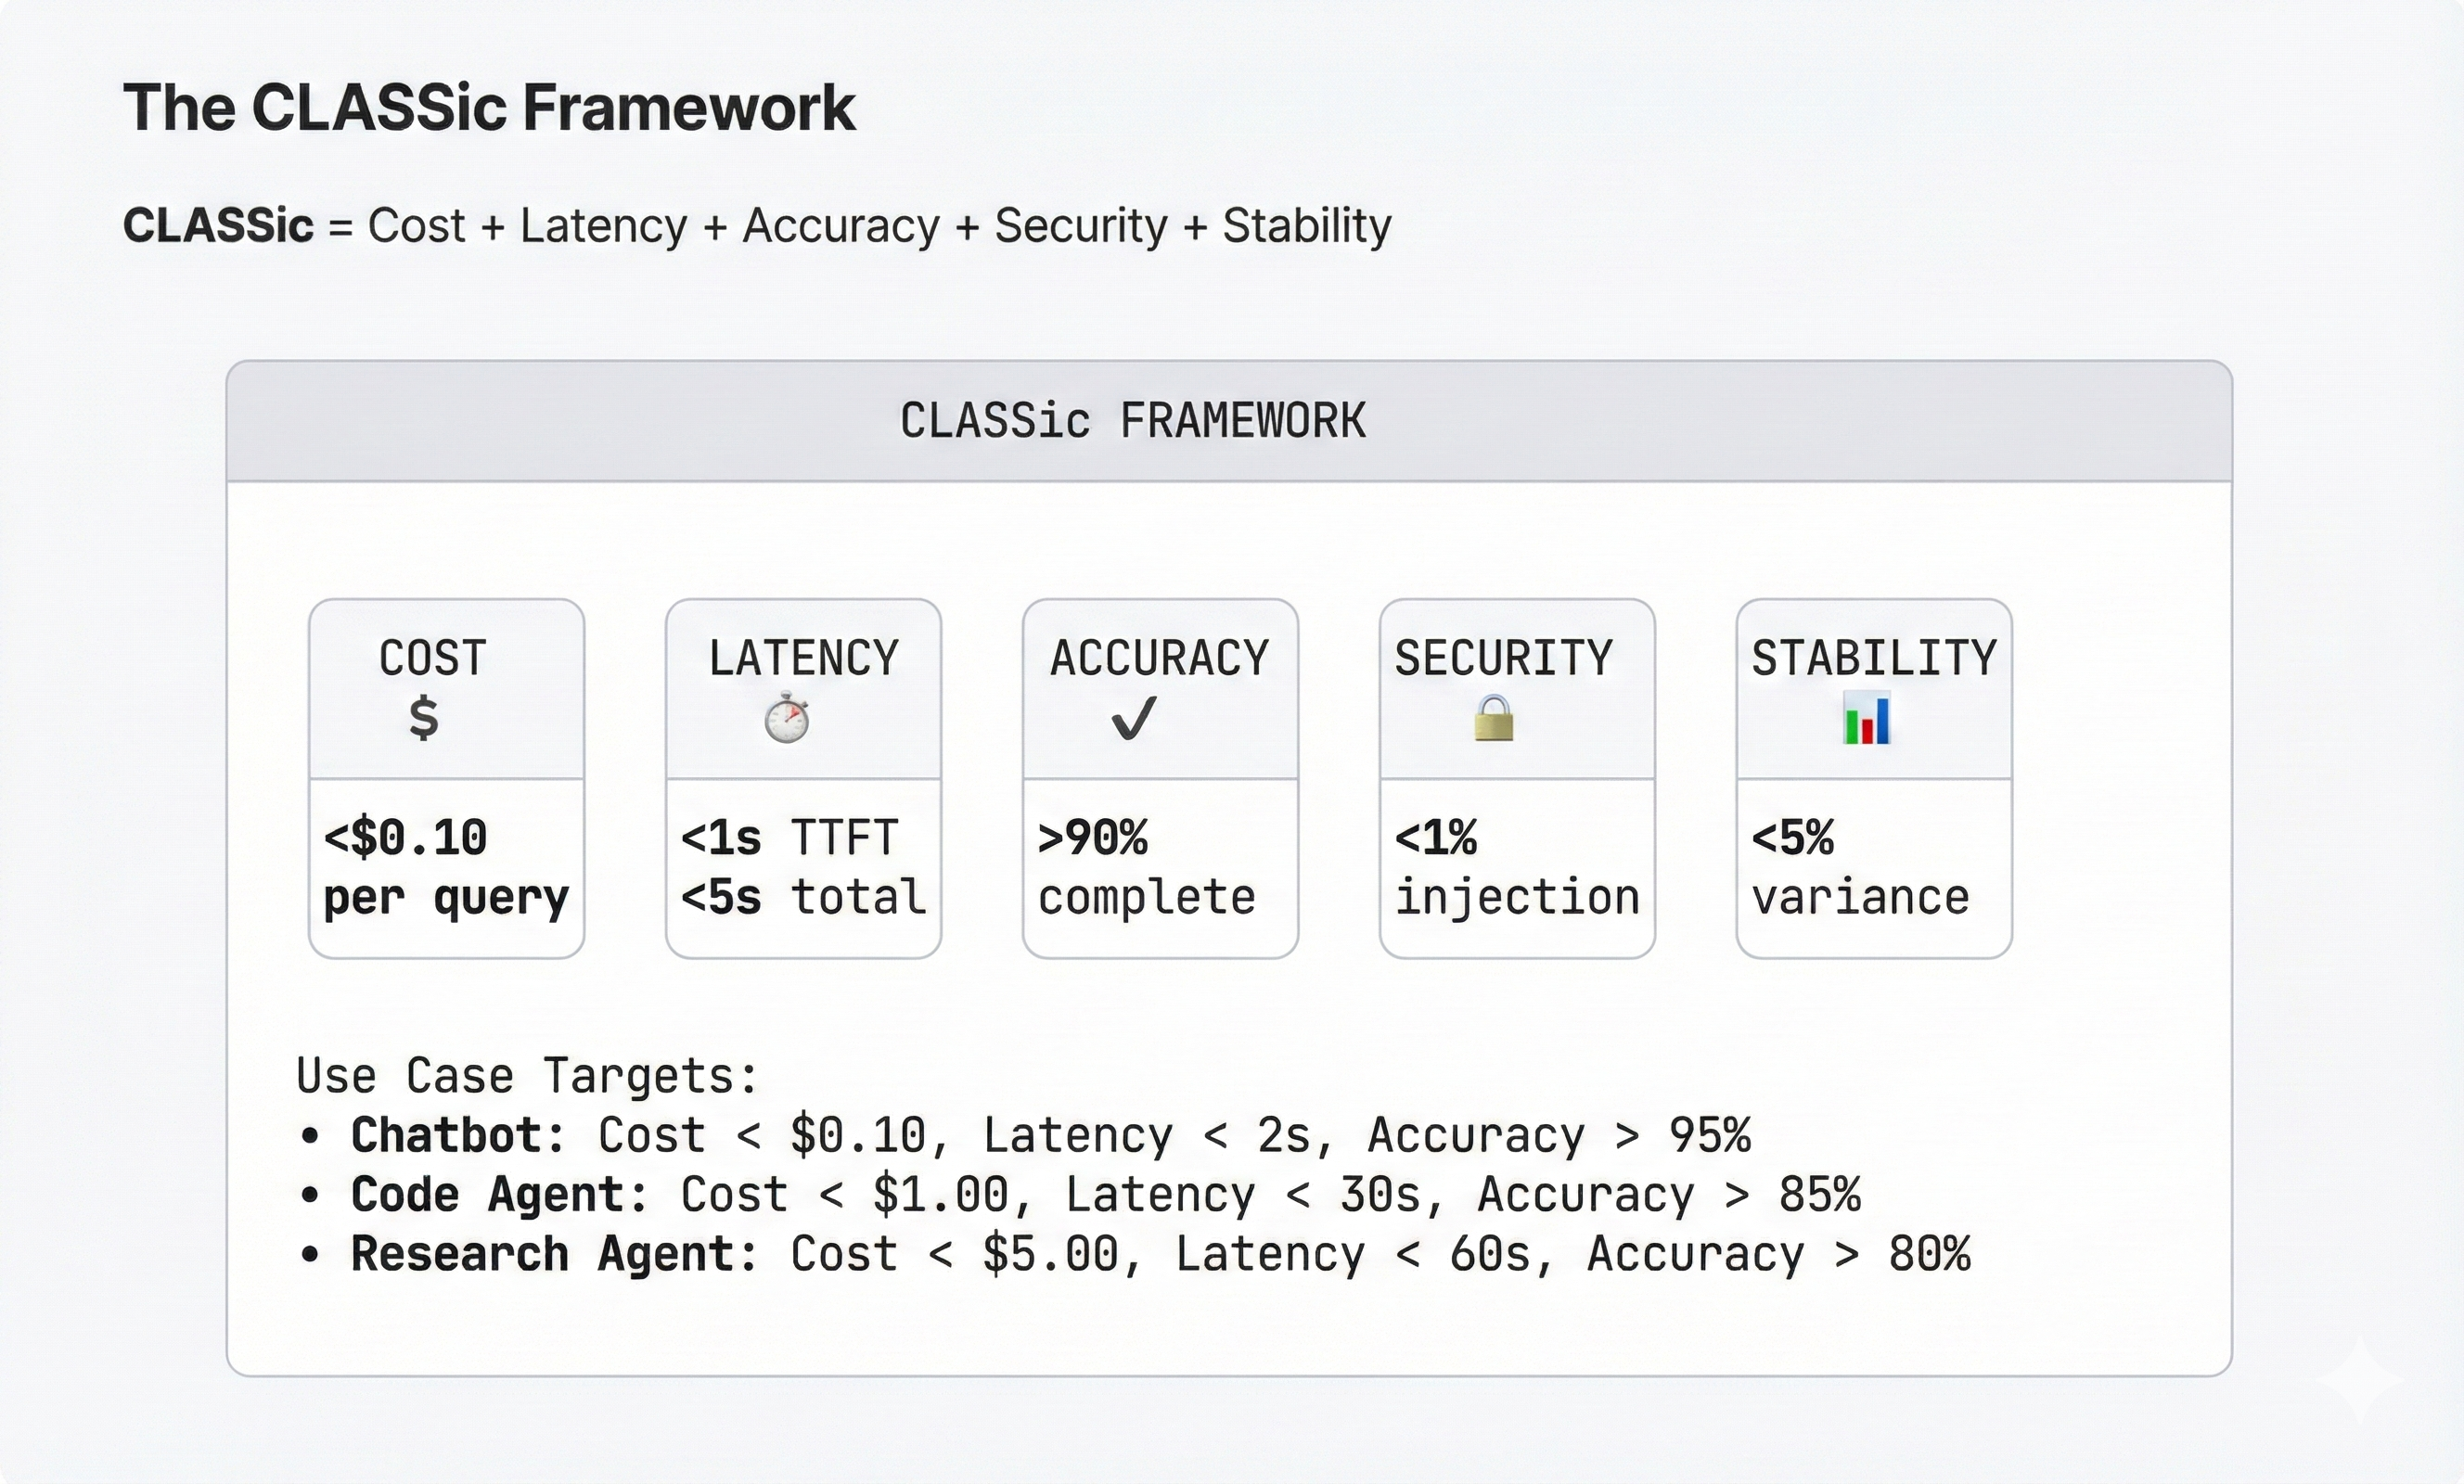

**TTFT = Time to first token**

### Agent-Specific Metrics Deep Dive

#### 1. Task Completion Rate

**Definition**: Percentage of tasks completed successfully end-to-end.

**Why it matters**: The ultimate measure of agent effectiveness.

| Agent Type | Target | Measurement |
|------------|--------|-------------|
| Customer Service | >95% | Did the agent resolve the query? |
| Code Generation | >90% | Did the code compile and pass tests? |
| Research | >85% | Did the agent answer the research question? |
| Incident Analysis | >90% | Did the postmortem identify root cause? |

**Key Consideration**: Define "success" clearly!
- Exact match vs semantic equivalence
- Partial credit for partial completion
- Time constraints (must complete within X seconds

**Evaluation approaches:**

- Deterministic checks: Compare final output against expected outcomes (e.g., "Did the API return status 200?", "Was the file created?")
- LLM-as-Judge: Ask an LLM to evaluate if the task was completed based on the goal and output
- Human annotation: Manual review for complex tasks

```python
# Deterministic example
def evaluate_task_completion(goal: str, final_state: dict) -> bool:
    if goal == "create_postmortem":
        return final_state.get("postmortem") is not None and len(final_state["postmortem"]) > 100
    return False

# LLM-as-Judge example (DeepEval)
from deepeval.metrics import GEval
task_completion = GEval(
    name="Task Completion",
    criteria="Did the agent successfully complete the user's requested task?",
    evaluation_params=["input", "actual_output"]
)
```


---

#### 2. Tool Correctness

For tool-using agents, correctness has **three dimensions**:

| Dimension | Question | Example |
|-----------|----------|--------|
| **Selection** | Did agent choose the right tool? | Used `search_web` instead of `search_database` |
| **Parameters** | Are parameters correct? | Passed valid date format, correct API key |
| **Sequence** | Is the order logical? | Search before summarize, read before write |

**Evaluation approaches:**

- Trajectory comparison: Compare tool calls against expected sequence
- Parameter validation: Check if tool arguments match expected schema/values
- Side-effect verification: Did the tool call produce expected changes?

```python
# DeepEval's ToolCorrectnessMetric
from deepeval.metrics import ToolCorrectnessMetric

metric = ToolCorrectnessMetric()

# You provide expected tools vs actual tools used
test_case = LLMTestCase(
    input="What's the weather in Paris?",
    actual_output="The weather in Paris is 22°C",
    expected_tools=["get_weather"],
    tools_called=["get_weather"]  # Extracted from trace
)
```

---

#### 3. Reasoning Quality

For agents that "think" (ReAct, Chain-of-Thought), we evaluate the reasoning chain:

| Aspect | What to Check | Red Flag |
|--------|---------------|----------|
| **Logical Consistency** | Each step follows from previous | Contradictions, non-sequiturs |
| **Step Necessity** | No redundant steps | Same tool called 5 times |
| **Goal Alignment** | Steps lead toward goal | Tangential exploration |
| **Loop Detection** | No infinite loops | Repeated action sequences |

**Infinite Loop Example**:
```
Step 1: Search for error → No results
Step 2: Search for error → No results  ← Repeating!
Step 3: Search for error → No results  ← Loop detected!
```

**Evaluation approaches:**

- Chain-of-thought analysis: LLM-as-Judge evaluates reasoning steps
- Step coherence: Are reasoning steps logically connected?
- Conclusion validity: Does the conclusion follow from the premises?

```python
# DeepEval's ToolCorrectnessMetric
# LLM-as-Judge with custom criteria
from deepeval.metrics import GEval

reasoning_quality = GEval(
    name="Reasoning Quality",
    criteria="""Evaluate the reasoning quality based on:
    1. Logical coherence - Do steps follow logically?
    2. Evidence usage - Are conclusions supported by data?
    3. No hallucinated reasoning - Are all claims grounded?
    4. Completeness - Are all relevant factors considered?""",
    evaluation_params=["input", "actual_output"],
    evaluation_steps=[
        "Identify the reasoning steps in the output",
        "Check if each step logically follows from previous steps",
        "Verify conclusions are supported by evidence",
        "Score from 0-1 based on overall reasoning soundness"
    ]
)
```


#### 4. Faithfulness & Groundedness

**Critical for RAG and agents that use external context.**

| Metric | Definition | Use Case |
|--------|------------|----------|
| **Faithfulness** | Is output grounded in retrieved context? | RAG systems, document Q&A |
| **Hallucination Rate** | % of claims not supported by context | Any LLM output |
| **Context Precision** | Are retrieved chunks relevant? | Retrieval quality |
| **Context Recall** | Did we retrieve all necessary info? | Retrieval completeness |

**For our incident-postmortem project:**
- Is the root cause analysis grounded in the log data?
- Are the timeline events supported by actual logs?
- Are the action items realistic based on the findings?

**Evaluation approaches:**

- Claim extraction + verification: Extract claims, check each against source
- NLI (Natural Language Inference): Use entailment models
- LLM-as-Judge: Ask if output is supported by context

```python
# DeepEval's FaithfulnessMetric
from deepeval.metrics import FaithfulnessMetric

faithfulness = FaithfulnessMetric(threshold=0.7)

test_case = LLMTestCase(
    input="Summarize the incident",
    actual_output="The database crashed at 2:30 PM due to connection pool exhaustion",
    retrieval_context=[
        "Log entry: 14:30:00 - DB connection pool exhausted",
        "Log entry: 14:30:05 - Database service unresponsive"
    ]
)

# Evaluates: Is every claim in the output supported by retrieval_context?
```

---

#### 5. Answer Relevancy

**Does the output actually answer the question asked?**

```
User Question: "What caused the API timeout yesterday?"

❌ Irrelevant: "Our API uses REST architecture with JSON..."
✅ Relevant: "The API timeout was caused by database connection pool exhaustion..."
```

**Evaluation approaches:**

- Question-answer alignment: Does the answer address the question?
- Reverse generation: Can you regenerate the question from the answer?
- Semantic similarity: Embedding similarity between question focus and answer

```python
# DeepEval's AnswerRelevancyMetric
from deepeval.metrics import AnswerRelevancyMetric

relevancy = AnswerRelevancyMetric(threshold=0.7)

test_case = LLMTestCase(
    input="What caused the database outage?",
    actual_output="The database outage was caused by connection pool exhaustion when traffic spiked 3x normal levels."
)

# Internally: Generates questions that the answer could address,
# then measures overlap with original question
```

---

#### 6. Safety & Policy Compliance

**What it measures:** Does the output violate safety guidelines or policies?

**Evaluation approaches:**

- Classifier-based: Use safety classifiers (OpenAI moderation, Perspective API)
- Rule-based: Regex/keyword matching for known violations
- LLM-as-Judge: Evaluate against policy document


| Check | Description | Target |
|-------|-------------|--------|
| Prompt Injection Resistance | Does agent resist manipulation? | <1% success rate |
| PII Handling | Does agent avoid exposing sensitive data? | 0 leaks |
| Harmful Content | Does agent refuse inappropriate requests? | 100% refusal |
| Authorization | Does agent stay within permitted actions? | 0 violations |

```python
# Using OpenAI's Moderation API
import openai

def check_safety(text: str) -> dict:
    response = openai.moderations.create(input=text)
    return {
        "flagged": response.results[0].flagged,
        "categories": response.results[0].categories
    }

# Custom policy compliance with GEval
from deepeval.metrics import GEval

policy_compliance = GEval(
    name="Policy Compliance",
    criteria="""Check if the output complies with these policies:
    1. No PII exposure (emails, phone numbers, SSNs)
    2. No harmful instructions
    3. No unauthorized data disclosure
    4. Professional tone maintained""",
    evaluation_params=["actual_output"]
)
```

---

## Part 3: Framework Comparison & Selection

### Evaluation Framework Landscape

| Framework | Best For | Key Differentiator | Pricing |
|-----------|----------|-------------------|---------|
| **DeepEval** | Dev/CI pipelines | pytest-style, 50+ metrics, native CI/CD | Free OSS, paid cloud |
| **RAGAS** | RAG evaluation | RAG-specific metrics (faithfulness, context) | Free OSS |
| **LangSmith** | LangChain users | Tight LangChain/LangGraph integration | Free tier, paid plans |
| **Langfuse** | Open-source/self-hosted | Open-source, cost tracking, privacy | Free OSS, paid cloud |
| **OpenAI Evals** | OpenAI models | Fine-tuning feedback, research | Free OSS |
| **Braintrust** | Rapid prototyping | Logging + evaluation combined | Paid |

### When to Use Which?

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    FRAMEWORK SELECTION GUIDE                            │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  "I need CI/CD integration with pytest-style tests"                     │
│      └──▶ DeepEval ✓                                                    │
│                                                                         │
│  "I'm building a RAG system and need retrieval metrics"                 │
│      └──▶ RAGAS ✓                                                       │
│                                                                         │
│  "I use LangChain/LangGraph and want integrated tracing + eval"         │
│      └──▶ LangSmith ✓                                                   │
│                                                                         │
│  "I need open-source, self-hosted, with cost tracking"                  │
│      └──▶ Langfuse ✓                                                    │
│                                                                         │
│  "I want to evaluate for OpenAI fine-tuning"                            │
│      └──▶ OpenAI Evals ✓                                                │
│                                                                         │
│  "I just want the simplest possible evaluation"                         │
│      └──▶ Start with DeepEval (pytest familiar, comprehensive)          │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
```

### Our Choice: DeepEval

For this workshop, we'll use **DeepEval** because:

1. **Developer-friendly**: pytest-style syntax (`deepeval test run`)
2. **CI/CD native**: Easy GitHub Actions / Jenkins integration
3. **Comprehensive**: 50+ built-in metrics for any use case
4. **Agent-aware**: Component-level + end-to-end evaluation
5. **Flexible**: Use any LLM as judge (OpenAI, Anthropic, local)

---

## Part 4: DeepEval Integration Demo

Let's integrate DeepEval with our **incident-postmortem** project from Session 2.

### Recap: Incident PostMortem Project

```
Architecture:
START → Log Analyzer → Root Cause → Writer ⟷ Reviewer → Finalize → END
                                       ↑_________|  
                                    (self-reflection loop)

Agents:
• Log Analyzer: Extracts patterns from incident logs
• Root Cause: Identifies why the incident occurred  
• Writer: Drafts the postmortem report
• Reviewer: LLM-as-Judge quality gate
```

### What We'll Evaluate

| Component | Metric | Why |
|-----------|--------|-----|
| Log Analyzer | Faithfulness | Is analysis grounded in logs? |
| Root Cause | Answer Relevancy | Does it identify the actual cause? |
| Writer | GEval (custom) | Is the postmortem well-structured? |
| Full Pipeline | Task Completion | Did we produce a quality report? |

In [ ]:
# Install DeepEval
# !pip install -U deepeval

print("DeepEval Installation")
print("=" * 60)
print("""  
To install DeepEval, run:

    pip install -U deepeval

Optional: Login to Confident AI for cloud reporting:

    deepeval login

To run tests:

    deepeval test run test_postmortem.py

    or 

    pytest test_postmortem.py -v
""")

In [ ]:
# DeepEval Concepts Overview

print("""
╔═══════════════════════════════════════════════════════════════════════╗
║                     DeepEval Core Concepts                           ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  1. TEST CASE (LLMTestCase)                                          ║
║     └─ A single unit of evaluation                                    ║
║     └─ Contains: input, actual_output, expected_output (optional)     ║
║     └─ Can include: context, retrieval_context                        ║
║                                                                       ║
║  2. METRICS                                                           ║
║     └─ AnswerRelevancyMetric: Does output answer the question?        ║
║     └─ FaithfulnessMetric: Is output grounded in context?             ║
║     └─ GEval: Custom criteria evaluation (most flexible)              ║
║     └─ HallucinationMetric: Does output contain hallucinations?       ║
║                                                                       ║
║  3. EVALUATION                                                        ║
║     └─ assert_test(): Pytest-style assertion                          ║
║     └─ evaluate(): Batch evaluation                                   ║
║     └─ @observe(): Component-level tracing                            ║
║                                                                       ║
║  4. THRESHOLD                                                         ║
║     └─ Scores range from 0-1                                          ║
║     └─ Default threshold: 0.5                                         ║
║     └─ Test passes if score >= threshold                              ║
║                                                                       ║
╚═══════════════════════════════════════════════════════════════════════╝
""")

In [ ]:
# Example: Evaluating PostMortem Report Quality

# Sample data from our incident-postmortem project
SAMPLE_INCIDENT_LOGS = """
2024-01-15 14:23:45 ERROR api-gateway Connection timeout after 30s to database-primary
2024-01-15 14:23:46 WARN api-gateway Retry attempt 1/3 for database connection
2024-01-15 14:23:47 ERROR api-gateway Connection timeout after 30s to database-primary  
2024-01-15 14:23:48 WARN api-gateway Retry attempt 2/3 for database connection
2024-01-15 14:23:49 ERROR api-gateway Connection timeout after 30s to database-primary
2024-01-15 14:23:50 CRITICAL api-gateway All database connections failed, service degraded
2024-01-15 14:24:00 ERROR user-service Failed to fetch user profile: database unavailable
2024-01-15 14:24:15 ERROR order-service Unable to process order: database timeout
"""

SAMPLE_ROOT_CAUSE = """
The API gateway experienced repeated connection timeouts to the primary database,
causing cascading failures across user-service and order-service. The root cause
was database connection pool exhaustion due to a memory leak in the connection
pooling library introduced in the v2.3.1 release.
"""

SAMPLE_POSTMORTEM = """
# Incident PostMortem: API Gateway Database Timeout

## Summary
On January 15, 2024, the API gateway experienced database connectivity issues
resulting in service degradation for 45 minutes.

## Timeline
- 14:23:45 - First database timeout detected
- 14:23:50 - Service entered degraded state after retry exhaustion
- 14:24:00 - Cascading failures in dependent services

## Root Cause
Database connection pool exhaustion caused by memory leak in connection pooling
library (v2.3.1).

## Action Items
1. Rollback connection pooling library to v2.3.0
2. Add connection pool monitoring alerts
3. Implement circuit breaker pattern for database connections
"""

print("Sample incident data loaded for evaluation demo")
print(f"  • Log entries: {len(SAMPLE_INCIDENT_LOGS.strip().split(chr(10)))} lines")
print(f"  • Root cause: {len(SAMPLE_ROOT_CAUSE.split())} words")
print(f"  • Postmortem: {len(SAMPLE_POSTMORTEM.split())} words")

In [ ]:
# DeepEval Test Case Structure

print("""
═══════════════════════════════════════════════════════════════════════════
TEST FILE: tests/test_postmortem_eval.py
═══════════════════════════════════════════════════════════════════════════
""")

test_file_content = '''
"""DeepEval tests for Incident PostMortem Agent."""

from deepeval import assert_test
from deepeval.test_case import LLMTestCase
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    GEval,
)
from deepeval.test_case import LLMTestCaseParams


# =============================================================================
# Test 1: Root Cause Faithfulness
# Is the root cause analysis grounded in the log data?
# =============================================================================

def test_root_cause_faithfulness():
    """Test that root cause analysis is faithful to log data."""
    
    faithfulness_metric = FaithfulnessMetric(
        threshold=0.7,
        model="gpt-4o",
        include_reason=True
    )
    
    test_case = LLMTestCase(
        input="Analyze the root cause of this incident",
        actual_output="""The root cause was database connection pool exhaustion 
        caused by a memory leak in the connection pooling library v2.3.1.""",
        retrieval_context=[
            "2024-01-15 14:23:45 ERROR Connection timeout to database-primary",
            "2024-01-15 14:23:50 CRITICAL All database connections failed",
            "Connection pool library v2.3.1 has known memory leak issue",
        ]
    )
    
    assert_test(test_case, [faithfulness_metric])


# =============================================================================
# Test 2: PostMortem Quality (Custom GEval)
# Does the postmortem meet quality standards?
# =============================================================================

def test_postmortem_quality():
    """Test postmortem report quality using custom criteria."""
    
    postmortem_quality_metric = GEval(
        name="PostMortem Quality",
        criteria="""Evaluate the incident postmortem report based on:
        1. Has a clear summary of the incident
        2. Includes a detailed timeline with timestamps
        3. Identifies a specific, actionable root cause
        4. Lists concrete action items to prevent recurrence
        5. Professional tone appropriate for stakeholder communication
        """,
        evaluation_params=[
            LLMTestCaseParams.INPUT,
            LLMTestCaseParams.ACTUAL_OUTPUT,
        ],
        threshold=0.7,
    )
    
    test_case = LLMTestCase(
        input="Generate a postmortem report for the database timeout incident",
        actual_output="""# Incident PostMortem: API Gateway Database Timeout
        
        ## Summary
        On January 15, 2024, the API gateway experienced database connectivity 
        issues resulting in service degradation for 45 minutes.
        
        ## Timeline
        - 14:23:45 - First database timeout detected
        - 14:23:50 - Service entered degraded state
        - 14:24:00 - Cascading failures in dependent services
        
        ## Root Cause
        Database connection pool exhaustion caused by memory leak.
        
        ## Action Items
        1. Rollback connection pooling library to v2.3.0
        2. Add connection pool monitoring alerts
        3. Implement circuit breaker pattern"""
    )
    
    assert_test(test_case, [postmortem_quality_metric])


# =============================================================================
# Test 3: Answer Relevancy
# Does the agent answer the question asked?
# =============================================================================

def test_answer_relevancy():
    """Test that responses are relevant to the query."""
    
    relevancy_metric = AnswerRelevancyMetric(
        threshold=0.7,
        model="gpt-4o"
    )
    
    test_case = LLMTestCase(
        input="What caused the API timeout on January 15th?",
        actual_output="""The API timeout on January 15th was caused by database 
        connection pool exhaustion. The connection pooling library v2.3.1 had a 
        memory leak that caused connections to not be properly released, eventually
        exhausting the pool and causing all database operations to timeout."""
    )
    
    assert_test(test_case, [relevancy_metric])


# =============================================================================
# Run with: deepeval test run tests/test_postmortem_eval.py
# =============================================================================
'''

print(test_file_content)

In [ ]:
# Running DeepEval Tests

print("""
═══════════════════════════════════════════════════════════════════════════
RUNNING DeepEval TESTS
═══════════════════════════════════════════════════════════════════════════

Command:
    deepeval test run tests/test_postmortem_eval.py

Expected Output:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Running 3 test(s)...

✓ test_root_cause_faithfulness
  Metric: FaithfulnessMetric
  Score: 0.85 (threshold: 0.7) ✓
  Reason: The root cause analysis directly references log events and is 
          grounded in the provided context.

✓ test_postmortem_quality  
  Metric: PostMortem Quality (GEval)
  Score: 0.78 (threshold: 0.7) ✓
  Reason: Report contains clear summary, timeline, root cause, and action items.
          Professional tone maintained throughout.

✓ test_answer_relevancy
  Metric: AnswerRelevancyMetric
  Score: 0.92 (threshold: 0.7) ✓
  Reason: Response directly answers the question about API timeout cause.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Test Results: 3 passed, 0 failed
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

View results: deepeval view

""")

In [ ]:
# CI/CD Integration Example

print("""
═══════════════════════════════════════════════════════════════════════════
CI/CD INTEGRATION: GitHub Actions Example
═══════════════════════════════════════════════════════════════════════════
""")

github_actions_yaml = '''
# .github/workflows/llm-eval.yml

name: LLM Evaluation

on:
  push:
    branches: [main]
  pull_request:
    branches: [main]

jobs:
  evaluate:
    runs-on: ubuntu-latest
    
    steps:
      - uses: actions/checkout@v4
      
      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: "3.11"
      
      - name: Install dependencies
        run: |
          pip install -r requirements.txt
          pip install deepeval
      
      - name: Run LLM Evaluation
        env:
          OPENAI_API_KEY: ${{ secrets.OPENAI_API_KEY }}
          CONFIDENT_API_KEY: ${{ secrets.CONFIDENT_API_KEY }}  # Optional
        run: |
          deepeval test run tests/test_postmortem_eval.py --verbose
      
      - name: Upload Results
        if: always()
        run: |
          deepeval view  # Opens results in Confident AI dashboard
'''

print(github_actions_yaml)

---

## Summary: Key Takeaways

### Why Evaluation Matters

| Without Evaluation | With Evaluation |
|-------------------|------------------|
| "Vibe testing" that doesn't scale | Automated, reproducible tests |
| Catch issues in production | Catch regressions in CI/CD |
| No quantitative improvement signal | Clear metrics to optimize |
| Expensive customer-found bugs | Cheap developer-found issues |

### Key Metrics for Agents

```
CLASSic Framework:
├── Cost:     < $0.10/query (chatbots) to < $1.00 (complex agents)
├── Latency:  < 1s TTFT, < 5s total (simple), < 30s (complex)  
├── Accuracy: Task completion > 90%
├── Security: Injection success < 1%, Data leakage = 0
└── Stability: Variance < 5% across runs

Agent-Specific:
├── Tool Correctness (selection, parameters, sequence)
├── Reasoning Quality (consistency, necessity, goal alignment)
├── Faithfulness (grounded in context)
└── Answer Relevancy (addresses the question)
```

### Framework Selection

| If you need... | Use |
|----------------|-----|
| pytest-style CI/CD testing | **DeepEval** |
| RAG-specific metrics | **RAGAS** |
| LangChain integration | **LangSmith** |
| Open-source observability | **Langfuse** |
| OpenAI fine-tuning evals | **OpenAI Evals** |

---

## Next: Module 2 - Observability & Cost Optimization

In the next module, we'll:
- Set up **Langfuse** for production observability
- Integrate tracing with the incident-postmortem project
- Learn cost optimization strategies (theory)

In [ ]:
# Module Complete!

print("""
╔═══════════════════════════════════════════════════════════════════════╗
║                                                                       ║
║  🎉 MODULE 1 COMPLETE: LLM Evaluation Frameworks                     ║
║                                                                       ║
╠═══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  ✅ What You Learned:                                                ║
║     • Why "vibe testing" doesn't scale                               ║
║     • CLASSic framework (Cost, Latency, Accuracy, Security, Stability)║
║     • Agent-specific metrics (tool correctness, faithfulness, etc.)  ║
║     • Framework comparison (DeepEval, RAGAS, LangSmith, Langfuse)    ║
║     • DeepEval integration for pytest-style LLM testing              ║
║                                                                       ║
║  📚 Resources:                                                        ║
║     • DeepEval: https://deepeval.com/docs/getting-started            ║
║     • RAGAS: https://docs.ragas.io/en/stable/concepts/               ║
║     • LangSmith: https://docs.langchain.com/langsmith/evaluation     ║
║     • Langfuse: https://langfuse.com/docs/evaluation/overview        ║
║                                                                       ║
║  ➡️  Next: Module 2 - Observability & Cost Optimization              ║
║                                                                       ║
╚═══════════════════════════════════════════════════════════════════════╝
""")